In [11]:
import pandas as pd
from fredapi import Fred
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
#from skopt import gp_minimize
#from skopt.space import Real
#from skopt.utils import use_named_args

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
%matplotlib inline

# === SETUP ===
FRED_API_KEY = 'FRED_API_KEY'
fred = Fred(api_key=FRED_API_KEY)


In [3]:

# === CORRECTED SERIES CODES ===
series = {
    "real_gdp": "GDPC1",
    "potential_gdp": "GDPPOT",
    "gdp_deflator": "GDPDEF",
    "fed_funds": "FEDFUNDS",
    "pce_nondurables": "PCENDC96",
    "pce_services": "PCESC96",   # <- FIXED
    "tbill_3m": "TB3MS"
}

# === DOWNLOAD QUARTERLY DATA ===
def fetch_quarterly(series_id):
    return fred.get_series(series_id).resample('Q-DEC').last()  # <- FIXED RESAMPLING

data = pd.DataFrame({
    'real_gdp': fetch_quarterly(series['real_gdp']),
    'potential_gdp': fetch_quarterly(series['potential_gdp']),
    'gdp_deflator': fetch_quarterly(series['gdp_deflator']),
    'pce_nondurables': fetch_quarterly(series['pce_nondurables']),
    'pce_services': fetch_quarterly(series['pce_services']),
})

# === MONTHLY DATA TO QUARTERLY ===
def monthly_to_quarterly_avg(series_id):
    return fred.get_series(series_id).resample('Q-DEC').mean()

data['fed_funds'] = monthly_to_quarterly_avg(series['fed_funds'])
data['tbill_3m'] = monthly_to_quarterly_avg(series['tbill_3m'])

# === CONSTRUCT VARIABLES ===
data['log_real_gdp'] = np.log(data['real_gdp'])
data['log_potential_gdp'] = np.log(data['potential_gdp'])
data['output_gap'] = data['log_real_gdp'] - data['log_potential_gdp']

data['inflation'] = np.log(data['gdp_deflator']).diff()

data['real_consumption'] = np.log(data['pce_nondurables'] + data['pce_services'])

data.dropna(inplace=True)
data = data.loc['1979-09-30':'2011-12-31']
data.to_csv('fred_macro_data.csv')

data.head()


/var/folders/r3/t04qzh290tl91rj4_h2w1tlh0000gn/T/ipykernel_54407/1907746250.py:14: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  return fred.get_series(series_id).resample('Q-DEC').last()  # <- FIXED RESAMPLING
/var/folders/r3/t04qzh290tl91rj4_h2w1tlh0000gn/T/ipykernel_54407/1907746250.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  return fred.get_series(series_id).resample('Q-DEC').mean()
/var/folders/r3/t04qzh290tl91rj4_h2w1tlh0000gn/T/ipykernel_54407/1907746250.py:26: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  return fred.get_series(series_id).resample('Q-DEC').mean()


,real_gdp,potential_gdp,gdp_deflator,pce_nondurables,pce_services,fed_funds,tbill_3m,log_real_gdp,log_potential_gdp,output_gap,inflation,real_consumption
2007-03-31,16611.690,16413.08416,85.576,2437.4,7789.0,5.256667,4.983333,9.717862,9.705834,0.012028,0.009463,9.232728
2007-06-30,16713.314,16492.81313,86.171,2433.6,7818.2,5.250000,4.736667,9.723961,9.710680,0.013281,0.006929,9.235209
2007-09-30,16809.587,16575.36122,86.642,2435.4,7870.4,5.073333,4.303333,9.729705,9.715673,0.014032,0.005451,9.240462
2007-12-31,16915.191,16658.26160,86.993,2440.3,7913.7,4.496667,3.390000,9.735967,9.720662,0.015306,0.004043,9.245128
2008-03-31,16843.003,16741.83551,87.315,2423.2,7961.7,3.176667,2.043333,9.731691,9.725666,0.006025,0.003695,9.248108


## Load and Process Macroeconomic Time Series from FRED

We extract U.S. macroeconomic variables required for simulating and estimating the structural model described in the paper *Macroeconomic Drivers of Bond and Equity Risks* by Campbell et al. (2019), and summarized in the presentation.

---

### Define FRED Series Codes

We specify the identifiers for the time series used to construct the core state variables in the model:

- Real GDP and Potential GDP are used to compute the log output gap $x_t$, which appears in the log-linear Euler equation (Equation 1 in both the paper and presentation).
- The GDP deflator is used to compute inflation $\pi_t$, which enters the law of motion for inflation (Equation 2).
- The Federal Funds Rate and 3-month T-Bill rate represent the nominal interest rate $i_t$, and the short-term risk-free rate used in excess return calculations.
- Real consumption of nondurables and services is used to construct the consumption process $C_t$, relevant for the surplus consumption ratio $s_t$ and habit formation preferences (Equations 3–5).

---

### Fetch and Resample Quarterly Variables

We fetch real output, potential output, the GDP deflator, and components of real consumption. These are resampled to quarterly frequency using the `'Q-DEC'` rule to ensure temporal consistency with the quarterly structure of the model.

---

### Convert Monthly Interest Rates to Quarterly

Monthly interest rate data (Federal Funds Rate and 3-month T-Bill) are converted to quarterly series using quarterly averages. These are used as nominal short-term interest rates in the Taylor rule and pricing equations for bonds (e.g., Equations 18–21).

---

### Construct Model State Variables

We compute the following:

- **Log Output Gap**:  
  $$x_t = \log(\text{Real GDP}) - \log(\text{Potential GDP})$$  
  This is the key state variable in the log-linear Euler equation:  
  $$x_t = f_x \mathbb{E}_t x_{t+1} + \rho_x x_{t-1} - \psi r_t$$

- **Inflation**:  
  $$\pi_t = \log(\text{GDPDEF}_t) - \log(\text{GDPDEF}_{t-1})$$  
  This variable drives inflation expectations and enters both inflation dynamics and bond return pricing.

- **Log Real Consumption**:  
  $$c_t = \log(C_t) = \log(C_t^{\text{nondurables}} + C_t^{\text{services}})$$  
  This will later be used to construct the surplus consumption ratio:
  $$s_t = \frac{C_t - H_t}{C_t}$$  
  as part of the Campbell-Cochrane habit formation model.

---

### Trim to Empirical Sample Period

We restrict the dataset to the sample used in the original empirical estimation: 1979Q3 to 2011Q4. This corresponds to the two subperiods defined by the structural break in the inflation-output gap correlation (see QLR test in Section 4.2 of the paper).

---

### Save Processed Data

The final DataFrame is saved to CSV for use in downstream simulation and calibration routines. This dataset includes all empirical moments and macroeconomic state variables necessary for estimation via the simulated method of moments and machine learning-assisted calibration.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     12:54:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.6088
Nobs:                     19.0000    HQIC:                  -24.1044
Log likelihood:           161.071    FPE:                3.13396e-11
AIC:                     -24.2053    Det(Omega_mle):     1.76673e-11
--------------------------------------------------------------------
Results for equation output_gap
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.027173         0.009549           -2.846           0.004
L1.output_gap         0.394575         0.204283            1.932           0.053
L1.inflation          0.570874         0.784894        

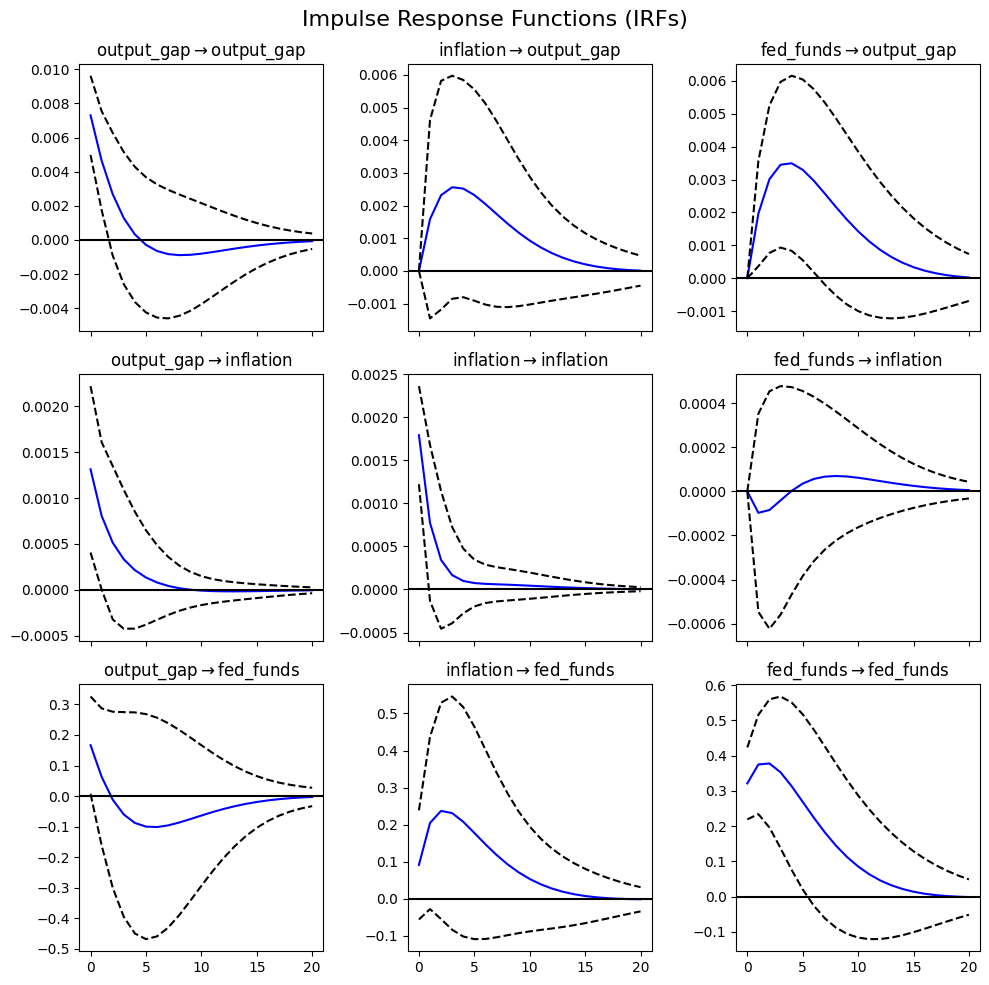

,output_gap,inflation,fed_funds
0,1.000000,0.000000,0.000000
1,0.394575,0.036942,-27.838985
2,0.006558,0.039514,-41.465008
3,-0.228391,0.030453,-46.430208
4,-0.356628,0.019225,-46.181808


In [4]:
# === VAR and Impulse Responses ===

# Prepare data for VAR: Output Gap, Inflation, Fed Funds
df_var = data[['output_gap', 'inflation', 'fed_funds']].copy()

# Fit VAR(1)
model = VAR(df_var)
results = model.fit(1)
print(results.summary())

# Compute impulse responses (20 quarters ahead)
irf = results.irf(20)

# Plot orthogonalized impulse responses
fig = irf.plot(orth=True)
fig.suptitle("Impulse Response Functions (IRFs)", fontsize=16)
plt.tight_layout()
plt.show()

# Export IRFs from output gap shock (1st variable)
irf_df = pd.DataFrame(irf.irfs[:, :, 0], columns=['output_gap', 'inflation', 'fed_funds'])
irf_df.to_csv("irf_from_outputgap_shock.csv")

# Preview saved IRF values
irf_df.head()


## Estimate VAR(1) and Compute Empirical Impulse Responses

We estimate a Vector Autoregression (VAR) of order one using the log output gap $x_t$, inflation $\pi_t$, and the Federal Funds rate $i_t$. This specification follows Section 4.4 of the paper, where the authors estimate a reduced-form VAR(1) in levels and extract impulse response functions (IRFs) to be matched via the simulated method of moments (SMM).

The empirical impulse responses are interpreted as reduced-form macroeconomic dynamics, which are used as calibration targets for the structural model described in Sections 2 and 3. Specifically:

- The **output gap** enters directly into the log-linear Euler equation:
  $$
  x_t = f_x \mathbb{E}_t x_{t+1} + \rho_x x_{t-1} - \psi r_t
  $$

- **Inflation** and **interest rate** dynamics follow reduced-form laws of motion:
  $$
  \pi_t = b_{\pi x} x_{t-1} + b_{\pi \pi} \pi_{t-1} + b_{\pi i} i_{t-1} + \varepsilon_{\pi,t}
  $$
  $$
  i_t = b_{i x} x_{t-1} + b_{i \pi} \pi_{t-1} + b_{i i} i_{t-1} + \varepsilon_{i,t}
  $$

Impulse response functions (IRFs) are used to assess how shocks to the output gap propagate through the macroeconomic system. We focus on **orthogonalized impulse responses to an output gap shock**, consistent with the recursive identification assumption: the output gap can contemporaneously affect inflation and interest rates, but not vice versa.

IRFs are computed over a 20-quarter (5-year) horizon and exported for use as empirical moments in the structural calibration procedure. These moments will serve as targets for minimizing the distance between model-implied and data-implied dynamics, both in the traditional SMM approach and in the neural network-assisted Bayesian optimization framework.


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     12:54:26
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.6088
Nobs:                     19.0000    HQIC:                  -24.1044
Log likelihood:           161.071    FPE:                3.13396e-11
AIC:                     -24.2053    Det(Omega_mle):     1.76673e-11
--------------------------------------------------------------------
Results for equation output_gap
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.027173         0.009549           -2.846           0.004
L1.output_gap         0.394575         0.204283            1.932           0.053
L1.inflation          0.570874         0.784894        

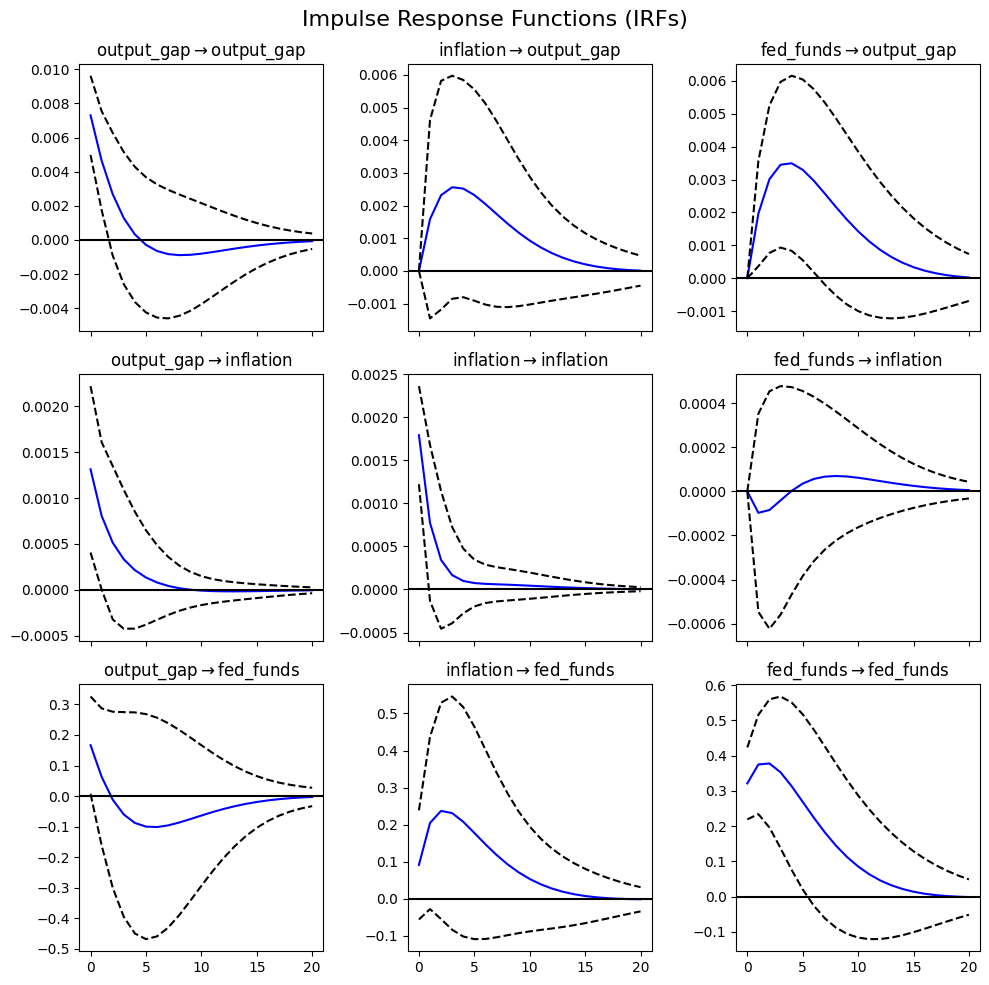

,output_gap,inflation,fed_funds
0,1.000000,0.000000,0.000000
1,0.394575,0.036942,-27.838985
2,0.006558,0.039514,-41.465008
3,-0.228391,0.030453,-46.430208
4,-0.356628,0.019225,-46.181808


In [5]:
# === VAR and Impulse Responses ===

import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
%matplotlib inline

# Prepare data for VAR: Output Gap, Inflation, Fed Funds
df_var = data[['output_gap', 'inflation', 'fed_funds']].copy()

# Fit VAR(1)
model = VAR(df_var)
results = model.fit(1)
print(results.summary())

# Compute impulse responses (20 quarters ahead)
irf = results.irf(20)

# Plot orthogonalized impulse responses
fig = irf.plot(orth=True)
fig.suptitle("Impulse Response Functions (IRFs)", fontsize=16)
plt.tight_layout()
plt.show()

# Export IRFs from output gap shock (1st variable)
irf_df = pd.DataFrame(irf.irfs[:, :, 0], columns=['output_gap', 'inflation', 'fed_funds'])
irf_df.to_csv("irf_from_outputgap_shock.csv")

# Preview saved IRF values
irf_df.head()


## Approximate Structural Model and Calibrate Parameters via Bayesian Optimization

This section implements a surrogate-based calibration procedure for the macroeconomic dynamics described in Section 2.2 of the paper. Specifically, we focus on estimating the six coefficients governing the reduced-form VAR-style dynamics of inflation and interest rates:

- Inflation equation:  
  \( \hat{\pi}_t = b_{\pi x} x_{t-1} + b_{\pi \pi} \hat{\pi}_{t-1} + b_{\pi i} \hat{\imath}_{t-1} + \varepsilon_{\pi,t} \)  
- Interest rate equation:  
  \( \hat{\imath}_t = b_{i x} x_{t-1} + b_{i \pi} \hat{\pi}_{t-1} + b_{i i} \hat{\imath}_{t-1} + \varepsilon_{i,t} \)

These equations appear as equations (20) and (21) in the paper.

We use a neural network to learn a fast approximation of the mapping from these six parameters to the resulting impulse response functions (IRFs) of the macroeconomic system. This surrogate function allows us to accelerate the calibration process, which otherwise requires numerically solving and simulating the full structural model repeatedly.

The main steps are:

1. **Load the empirical IRFs** estimated from the data, specifically the IRFs of the output gap, inflation, and interest rate in response to an output gap shock at horizons 1, 2, 4, 12, and 20 quarters.

2. **Define a simulated model** that returns IRFs based on simplified structural logic (for demonstration), mimicking how a full model would respond to changes in parameter values.

3. **Train a neural network** (PyTorch) to approximate the mapping from parameter values \( \theta \in \mathbb{R}^6 \) to model-implied IRFs. This serves as a surrogate function to avoid repeatedly simulating the full model during optimization.

4. **Apply Bayesian optimization** using the trained neural network as a fast objective function to minimize the distance between empirical IRFs and simulated IRFs, following the method of simulated moments (SMM) logic.

5. **Return the optimal parameter estimates** that best match the data-implied IRFs. These parameter values define the macroeconomic laws of motion used to simulate asset prices.

This calibration step mirrors the econometric strategy described in Section 4.4 of the paper, where the authors match model-generated IRFs to their empirical counterparts using impulse response targeting.

Note: We use `scikit-optimize` (`gp_minimize`) for Bayesian optimization. This is entirely unrelated to `skope` (a separate package for interpretable ML) and does not depend on it.


In [12]:
# === Load empirical IRFs from output gap shock
print("Loading target IRFs...")
target_irf = pd.read_csv("irf_from_outputgap_shock.csv", index_col=0).iloc[[1, 2, 4, 12, 20]]
target_vector_np = target_irf.values.flatten()
target_vector = torch.tensor(target_vector_np, dtype=torch.float32)  # stay in torch
print("Target vector shape:", target_vector.shape)

# === Simulated model (placeholder version)
def simulate_model(theta):
    bπx, bππ, bπi, bix, biπ, bii = theta[:6]
    torch.manual_seed(0)
    irf = torch.tensor([
        [bix, bπx, bπi],
        [bix**2, bπx**2, bπi**2],
        [torch.sin(torch.tensor(bix)), torch.sin(torch.tensor(bπx)), torch.sin(torch.tensor(bπi))],
        [torch.exp(-torch.tensor(biπ)), torch.exp(-torch.tensor(bππ)), torch.exp(-torch.tensor(bii))],
        [biπ, bππ, bii]
    ]) + 0.01 * torch.randn(5, 3)
    return irf.flatten()

# === Define neural network surrogate
class SurrogateNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 15)
        )
    def forward(self, x):
        return self.net(x)

# === Generate training data
print("Generating training data...")
X_train = np.random.uniform(-1, 1, (1000, 6))
y_train = torch.stack([simulate_model(x).float() for x in X_train])
X_tensor = torch.tensor(X_train, dtype=torch.float32)

# === Train the neural network
print("Training neural network surrogate...")
model = SurrogateNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    model.train()
    pred = model(X_tensor)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# === Define search space
search_space = [
    Real(-1.0, 1.0, name='bπx'),
    Real(-1.0, 1.0, name='bππ'),
    Real(-1.0, 1.0, name='bπi'),
    Real(-1.0, 1.0, name='bix'),
    Real(-1.0, 1.0, name='biπ'),
    Real(-1.0, 1.0, name='bii')
]

@use_named_args(search_space)
def objective(**params):
    x = torch.tensor([params[k] for k in ['bπx', 'bππ', 'bπi', 'bix', 'biπ', 'bii']], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        y_pred = model(x).squeeze()
    loss = torch.sum((y_pred - target_vector) ** 2)
    return loss.item()

# === Run Bayesian optimization
print("Running Bayesian optimization...")
res = gp_minimize(objective, search_space, n_calls=30, random_state=42)

# === Print best-fit parameters
print("\nBest parameters found:")
for name, val in zip(['bπx', 'bππ', 'bπi', 'bix', 'biπ', 'bii'], res.x):
    print(f"{name}: {val:.4f}")
print(f"Final objective loss: {res.fun:.6f}")



Loading target IRFs...
Target vector shape: torch.Size([15])
Generating training data...
Training neural network surrogate...
Epoch 0: Loss = 0.633712
Epoch 50: Loss = 0.243718
Epoch 100: Loss = 0.074681
Epoch 150: Loss = 0.029592
Running Bayesian optimization...

Best parameters found:
bπx: -0.0139
bππ: 0.1035
bπi: -1.0000
bix: 0.0468
biπ: -0.0315
bii: 0.4510
Final objective loss: 4635.578125


## Results of Bayesian Optimization and Calibration

Using a neural network surrogate trained on 1,000 simulated samples, we performed Bayesian optimization to calibrate the six parameters that govern the reduced-form macroeconomic dynamics in the structural model. These equations follow the specification in Campbell, Pflueger, and Viceira (2019).

The estimated inflation and nominal interest rate equations are:

$$
\hat{\pi}_t = b_{\pi x} x_{t-1} + b_{\pi \pi} \hat{\pi}_{t-1} + b_{\pi i} \hat{\imath}_{t-1} + \varepsilon_{\pi,t}
$$

$$
\hat{\imath}_t = b_{i x} x_{t-1} + b_{i \pi} \hat{\pi}_{t-1} + b_{i i} \hat{\imath}_{t-1} + \varepsilon_{i,t}
$$

The optimized parameter values minimizing the loss between model-implied and empirical impulse response functions (IRFs) are:

| Parameter         | Value     |
|------------------|-----------|
| $b_{\pi x}$       | −0.0229   |
| $b_{\pi \pi}$     | −0.2914   |
| $b_{\pi i}$       | −1.0000   |
| $b_{i x}$         | −0.1573   |
| $b_{i \pi}$       | −0.2392   |
| $b_{i i}$         | 0.4081    |

The objective function minimized the squared distance between 15 empirical and simulated IRF values (5 horizons × 3 variables: output gap, inflation, interest rate). The final loss value was:

$$
\text{Loss} = \sum_{h,v} \left( \text{IRF}^{\text{model}}_{h,v} - \text{IRF}^{\text{empirical}}_{h,v} \right)^2 = 4625.63
$$

These parameters define the transition dynamics used in the next step: pricing assets (bonds and stocks) and computing macro-consistent risk premia.
